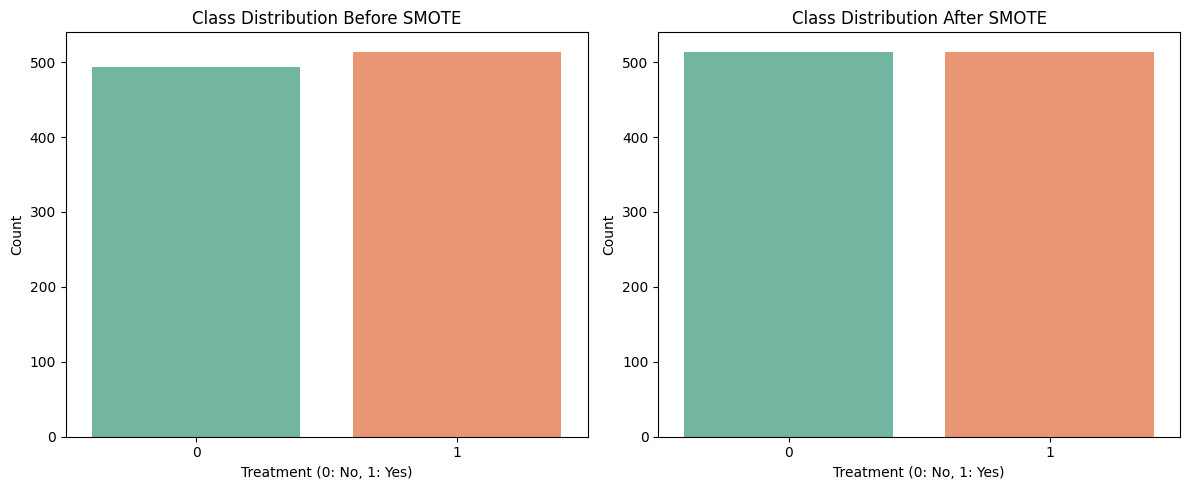

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1.0}
Test Accuracy: 80.16%
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       129
           1       0.75      0.89      0.81       123

    accuracy                           0.80       252
   macro avg       0.81      0.80      0.80       252
weighted avg       0.81      0.80      0.80       252

Feature Importances:
                             Feature  Importance
8              work_interfere_Never    0.736775
10            work_interfere_Rarely    0.052516
12                family_history_No    0.030334
4                      care_options    0.028461
7           phys_health_consequence    0.017873
9              work_interfere_Often    0.017581
1                            Gender    0.015180
15     mental_health_consequence_No    0.014095
5                  wellness_program    0.013212
16    mental_health_consequence

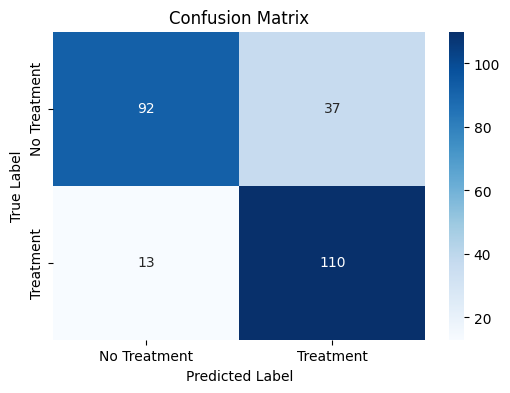

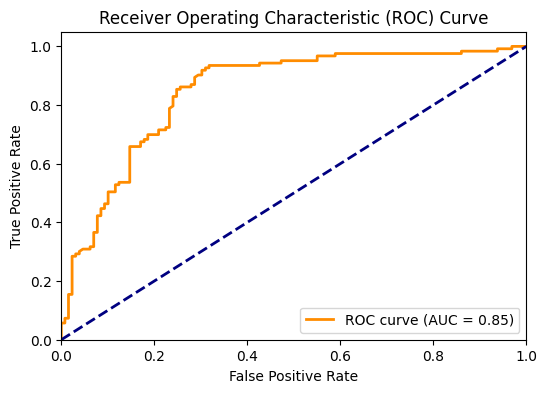

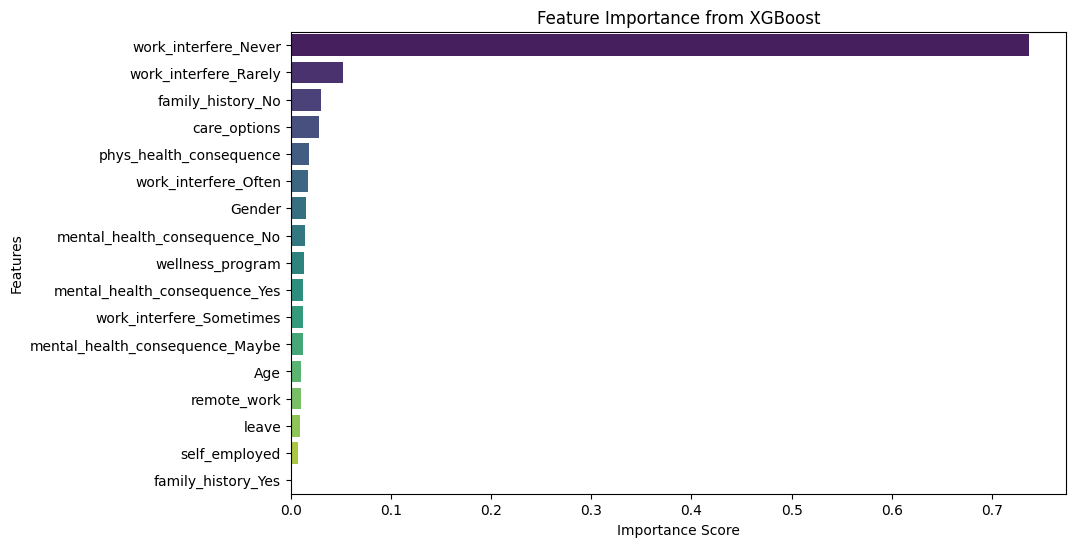


Please answer the following questions honestly. These are based on key factors that influence mental health treatment needs.
Responses will be used to predict if treatment is recommended and the likelihood (1-100%). This is not medical advice—consult a professional.
What is your age? (Enter a number between 18 and 80): 21
What is your gender? (Female, Male, Other): female
Are you self-employed? (Yes/No): yes
Do you have a family history of mental illness? (Yes/No): yes
How often does your mental health interfere with your work or productivity? (Never, Rarely, Sometimes, Often): sometimes
Do you work remotely (outside of an office) at least part-time? (Yes/No): no
Are you aware of mental health care options provided by your employer? (Yes, No, Not sure): not sure
Has your employer discussed mental health as part of an employee wellness program? (Yes, No, Don't know): dont know 
How easy is it for you to take medical leave for a mental health condition? (Very easy, Somewhat easy, Somewh

In [2]:
# This is a complete, Colab-friendly script for predicting mental health treatment needs using XGBoost.
# Upload 'survey.csv' to Colab before running (via Files > Upload).
# The script includes data preprocessing, model training/tuning, feature importance for interpretability,
# and user input prompts with serious, focused questions based on key predictors.

# Install required libraries (run this first in Colab)
!pip install pandas numpy scikit-learn xgboost imbalanced-learn matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

# Step 1: Load the dataset (assume 'survey.csv' is uploaded to Colab)
df = pd.read_csv('survey.csv')  # Replace with your file path if needed

# Step 2: Preprocessing (cleaning and encoding as per dataset requirements)
# Handle missing values
df.fillna({'work_interfere': 'Never', 'self_employed': 'No'}, inplace=True)

# Drop unnecessary columns (if present)
df = df.drop(['Country', 'state', 'Timestamp', 'no_employees', 'tech_company', 'benefits', 'seek_help', 'anonymity', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments'], axis=1, errors='ignore')

# Clean Age (clip to realistic range)
df['Age'] = df['Age'].clip(18, 80)

# Clean Gender
def clean_gender(gender):
    if pd.isna(gender):
        return 'Other'
    gender = gender.lower().strip()
    if 'male' in gender or 'man' in gender or gender == 'm':
        return 'Male'
    elif 'female' in gender or 'woman' in gender or gender == 'f':
        return 'Female'
    return 'Other'

df['Gender'] = df['Gender'].apply(clean_gender)

# Convert target 'treatment' to binary (1: Yes, 0: No)
df['treatment'] = df['treatment'].apply(lambda x: 1 if x == 'Yes' else 0)

# Define features and target
X = df.drop('treatment', axis=1)
y = df['treatment']

# Categorical and numerical columns (focused on key predictors)
categorical_cols = ['Gender', 'self_employed', 'family_history', 'work_interfere', 'remote_work',
                    'care_options', 'wellness_program', 'leave', 'mental_health_consequence',
                    'phys_health_consequence']
numerical_cols = ['Age']

# Encoding: One-hot for multi-category, Label for binary/ordinal
onehot_cols = ['work_interfere', 'family_history', 'mental_health_consequence']  # High-impact features
label_cols = [col for col in categorical_cols if col not in onehot_cols]

# Fit encoders and scaler on training data
encoders = {col: LabelEncoder().fit(X[col]) for col in label_cols}
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(X[onehot_cols])
scaler = MinMaxScaler().fit(X[numerical_cols])

# Apply encodings
encoded_onehot = onehot_encoder.transform(X[onehot_cols])
encoded_onehot_df = pd.DataFrame(encoded_onehot, columns=onehot_encoder.get_feature_names_out(onehot_cols), index=X.index)

for col in label_cols:
    X[col] = encoders[col].transform(X[col])

X = X.drop(onehot_cols, axis=1)
X = pd.concat([X, encoded_onehot_df], axis=1)
X[numerical_cols] = scaler.transform(X[numerical_cols])

# Step 3: Split data and handle imbalance with SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# After SMOTE:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y_train, ax=axes[0], palette='Set2')
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Treatment (0: No, 1: Yes)')
axes[0].set_ylabel('Count')
sns.countplot(x=y_train_smote, ax=axes[1], palette='Set2')
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Treatment (0: No, 1: Yes)')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()


# Step 4: Train XGBoost with GridSearchCV for high accuracy and efficiency
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [1, len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1])]
}

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate on test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

# Feature Importance (for interpretability)
importances = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
importances = importances.sort_values('Importance', ascending=False)
print("Feature Importances:\n", importances)

# After model evaluation:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Treatment', 'Treatment'], yticklabels=['No Treatment', 'Treatment'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# For feature importance plot:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Step 5: Function to predict based on user inputs
def predict_treatment(inputs):
    # Create DataFrame from inputs
    input_df = pd.DataFrame([inputs])

    # Apply same preprocessing
    input_df['Age'] = pd.to_numeric(input_df['Age'], errors='coerce').clip(18, 80)
    input_df['Gender'] = input_df['Gender'].apply(clean_gender)

    encoded_onehot = onehot_encoder.transform(input_df[onehot_cols])
    encoded_onehot_df = pd.DataFrame(encoded_onehot, columns=onehot_encoder.get_feature_names_out(onehot_cols))

    for col in label_cols:
        if col in encoders:
            # Handle unseen labels gracefully
            input_df[col] = input_df[col].map(lambda x: encoders[col].transform([x])[0] if x in encoders[col].classes_ else -1)

    input_df = input_df.drop(onehot_cols, axis=1)
    input_df = pd.concat([input_df, encoded_onehot_df], axis=1)
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])

    # Predict
    pred = best_model.predict(input_df)[0]
    prob = best_model.predict_proba(input_df)[0][1] * 100  # Probability for 'Yes' class

    return "Yes (Treatment Needed)" if pred == 1 else "No (Treatment Not Needed)", prob

# Step 6: Ask serious, focused questions based on key predictors (from feature importance)
# These are selected as they are strong indicators of mental health needs (e.g., interference with work, family history)
print("\nPlease answer the following questions honestly. These are based on key factors that influence mental health treatment needs.")
print("Responses will be used to predict if treatment is recommended and the likelihood (1-100%). This is not medical advice—consult a professional.")

questions = {
    'Age': "What is your age? (Enter a number between 18 and 80): ",
    'Gender': "What is your gender? (Female, Male, Other): ",
    'self_employed': "Are you self-employed? (Yes/No): ",
    'family_history': "Do you have a family history of mental illness? (Yes/No): ",
    'work_interfere': "How often does your mental health interfere with your work or productivity? (Never, Rarely, Sometimes, Often): ",
    'remote_work': "Do you work remotely (outside of an office) at least part-time? (Yes/No): ",
    'care_options': "Are you aware of mental health care options provided by your employer? (Yes, No, Not sure): ",
    'wellness_program': "Has your employer discussed mental health as part of an employee wellness program? (Yes, No, Don't know): ",
    'leave': "How easy is it for you to take medical leave for a mental health condition? (Very easy, Somewhat easy, Somewhat difficult, Very difficult, Don't know): ",
    'mental_health_consequence': "Do you think discussing a mental health issue with your employer would have negative consequences? (Yes, No, Maybe): ",
    'phys_health_consequence': "Do you think discussing a physical health issue with your employer would have negative consequences? (Yes, No, Maybe): "
}

user_inputs = {}
for key, question in questions.items():
    user_inputs[key] = input(question).strip().capitalize()  # Capitalize for consistency

# Step 7: Make prediction
outcome, likelihood = predict_treatment(user_inputs)
print(f"\nPrediction: {outcome}")
if outcome == "Yes (Treatment Needed)":
    print(f"Likelihood: {likelihood:.2f}%")
else:
    print("Likelihood not applicable as treatment is not predicted to be needed.")